In [17]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
with open("data/eval_top3_results_labeled_Alireza.json", "r") as f:
    alireza_data = json.load(f)
with open("data/eval_top3_results_labeled_Asal.json", "r") as f:
    asal_data = json.load(f)

In [19]:
def compute_metrics(data, k=3):
    methods = ["tfidf_top3", "glot500_base_top3", "glot500_lora_top3"]
    metrics = {m: {"MeanRank": [], "MedianRank": [], "WorstRank": [],
                   "TopKCount": 0, "Top1Count": 0, "MRR": []} for m in methods}
    for entry in data:
        labels = entry["label"]
        for i, m in enumerate(methods):
            ranks = labels[i*3:(i+1)*3]
            metrics[m]["MeanRank"].append(np.mean(ranks))
            metrics[m]["MedianRank"].append(np.median(ranks))
            metrics[m]["WorstRank"].append(max(ranks))
            metrics[m]["TopKCount"] += sum(1 for r in ranks if r <= k)
            metrics[m]["Top1Count"] += sum(1 for r in ranks if r == 1)
            metrics[m]["MRR"].append(1.0 / min(ranks))
    summary = {}
    n_questions = len(data)
    for m in methods:
        summary[m] = {
            "MeanRank": np.mean(metrics[m]["MeanRank"]),
            "MedianRank": np.median(metrics[m]["MedianRank"]),
            "WorstRankCount": sum(1 for x in metrics[m]["WorstRank"] if x == 9),
            "TopKCount": metrics[m]["TopKCount"],
            "TopK%": metrics[m]["TopKCount"] / (n_questions*3) * 100,
            "Top1Count": metrics[m]["Top1Count"],
            "Top1%": metrics[m]["Top1Count"] / (n_questions*3) * 100,
            "MRR": np.mean(metrics[m]["MRR"])
        }
    return summary

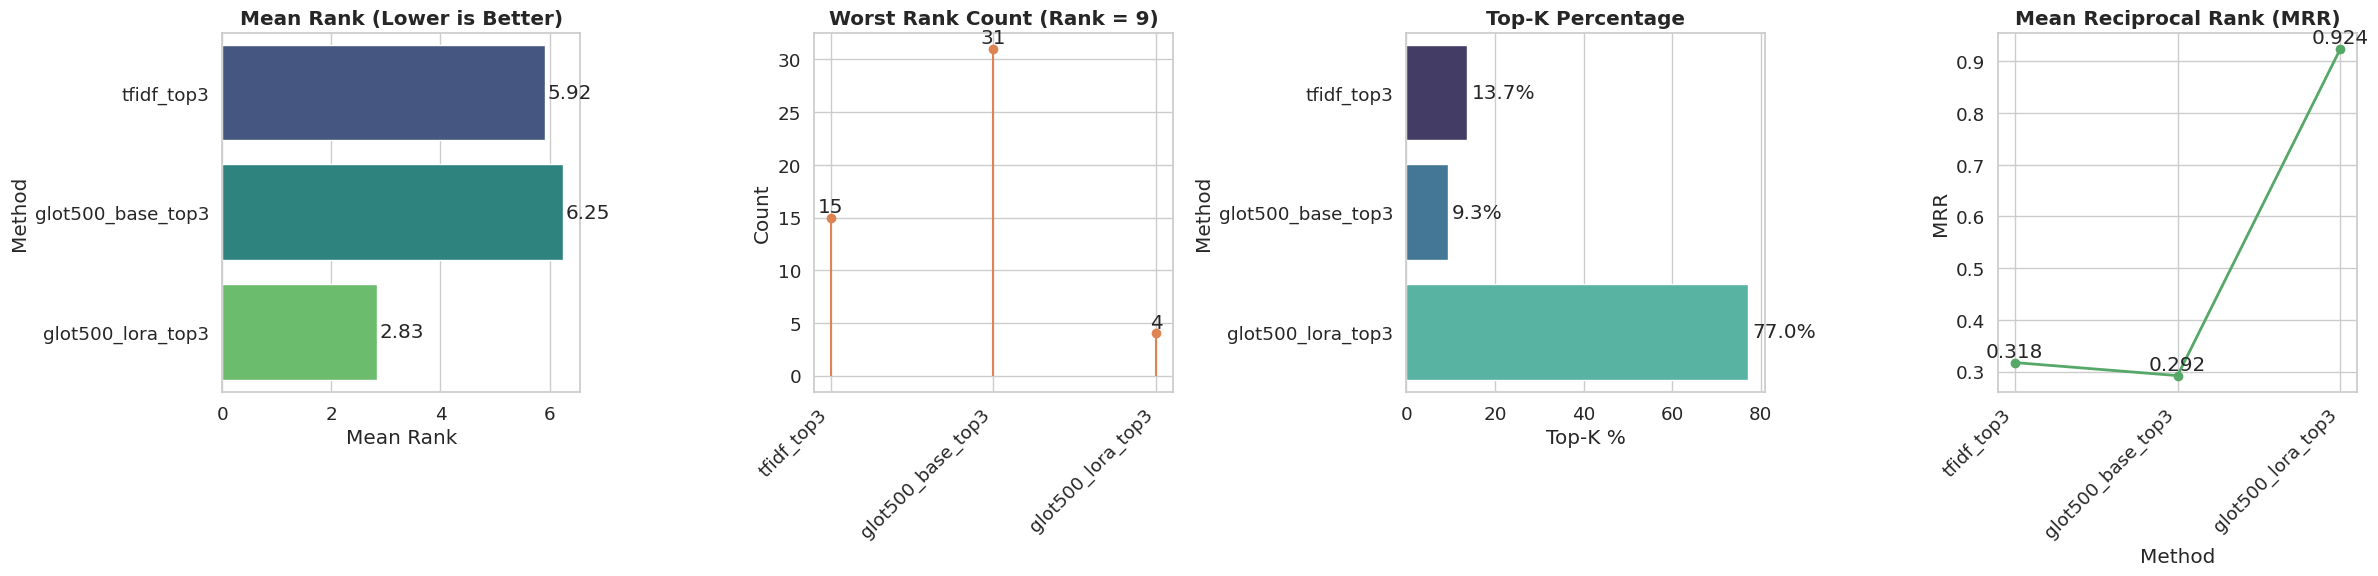

In [21]:
alireza_summary = compute_metrics(alireza_data)
asal_summary = compute_metrics(asal_data)

df_alireza = pd.DataFrame(alireza_summary).T
df_asal = pd.DataFrame(asal_summary).T
df_alireza.to_csv("data/annotator_Alireza_metrics.csv")
df_asal.to_csv("data/annotator_Asal_metrics.csv")

methods = ["tfidf_top3", "glot500_base_top3", "glot500_lora_top3"]
overall_summary = {}
for m in methods:
    overall_summary[m] = {}
    for metric in df_alireza.columns:
        overall_summary[m][metric] = (df_alireza.loc[m, metric] + df_asal.loc[m, metric]) / 2
df_overall = pd.DataFrame(overall_summary).T
df_overall.to_csv("data/overall_metrics.csv")
df_overall[["MedianRank"]].to_csv("data/medianrank_table.csv")

sns.set_theme(style="whitegrid", font_scale=1.2)
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

sns.barplot(data=df_overall.reset_index(), x="MeanRank", y="index", hue="index", palette="viridis", legend=False, ax=axes[0])
axes[0].set_title("Mean Rank (Lower is Better)", weight="bold")
axes[0].set_xlabel("Mean Rank")
axes[0].set_ylabel("Method")
for i, v in enumerate(df_overall["MeanRank"]):
    axes[0].text(v + 0.05, i, f"{v:.2f}", va='center')

x = df_overall.index
y = df_overall["WorstRankCount"]
axes[1].stem(range(len(x)), y, linefmt="C1-", markerfmt="o", basefmt=" ")
axes[1].set_xticks(range(len(x)))
axes[1].set_xticklabels(x, rotation=45, ha='right')
axes[1].set_title("Worst Rank Count (Rank = 9)", weight="bold")
axes[1].set_ylabel("Count")
for i, v in enumerate(y):
    axes[1].text(i, v + 0.5, str(int(v)), ha='center')

sns.barplot(data=df_overall.reset_index(), x="TopK%", y="index", hue="index", palette="mako", legend=False, ax=axes[2])
axes[2].set_title("Top-K Percentage", weight="bold")
axes[2].set_xlabel("Top-K %")
axes[2].set_ylabel("Method")
for i, v in enumerate(df_overall["TopK%"]):
    axes[2].text(v + 1, i, f"{v:.1f}%", va='center')

axes[3].plot(range(len(df_overall.index)), df_overall["MRR"], marker="o", color="C2", linewidth=2)
axes[3].set_xticks(range(len(df_overall.index)))
axes[3].set_xticklabels(df_overall.index, rotation=45, ha='right')
axes[3].set_title("Mean Reciprocal Rank (MRR)", weight="bold")
axes[3].set_ylabel("MRR")
axes[3].set_xlabel("Method")
for i, v in enumerate(df_overall["MRR"]):
    axes[3].text(i, v + 0.01, f"{v:.3f}", ha='center')

plt.tight_layout()
plt.savefig("data/combined_metrics_figure.png", dpi=300)
plt.show()

In [ ]:
!rm -rf da